<div class="colab-button-container">
  <a href="https://colab.research.google.com/github/username/project/blob/main/notebooks/scrna_tutorial.ipynb"
     target="_blank"
     class="colab-top-button"
     title="Open this notebook in Google Colab">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"
         alt="Open in Colab"
         class="colab-badge">
  </a>
</div>

---
format:
  html:
    page-layout: full
    mainfont: "Inter"
    toc: true
---

<h1>Introductory scRNA-seq Analysis with `kb-python` and `ScanPy`</h1>
<h4>Written by Maya Caskey (based off older versions by Joe Rich, Kyung Hoi (Joseph) Min, A. Sina Booeshaghi and Lior Pachter)</h4>
<br>

This notebook demonstrates pre-processing and basic analysis of the [1k Human PBMCs](https://www.10xgenomics.com/datasets/1-k-human-pbm-cs-stained-with-a-panel-of-total-seq-b-antibodies-single-indexed-3-1-standard-4-0-0) dataset from 10x Genomics using the **10x Genomics Chromium Single Cell 3' Next Gen v3.1** assay.

## An Introductory Analysis Pipeline

There are many ways to perform a single-cell RNA sequencing (scRNA-seq) analysis and many aspects of your data to explore. In this tutorial, we outline a basic approach to quality control and analysis, along with some intuitive explanation of the underlying mathematics.

:::{.highlight-section}
This scRNA-seq workflow has the following steps:

1. Read Alignment
2. Quality Control
3. Cell and Gene Filters
4. Normalization and Variance Stabilization
5. Dimensionality Reduction
6. Clustering and Visualization
7. Differential Expression
:::

## Initial Set-Up

### Install Python Packages

In [ ]:
# @title
!pip install --quiet scanpy python-igraph louvain pybiomart
!pip install --quiet matplotlib
!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scipy

!pip install --quiet kb-python==0.29.1

In [ ]:
# @title
# Import packages
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

matplotlib.rcParams.update({'font.size': 12})
set_matplotlib_formats('retina')

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


### Download the scRNA-seq data

In [ ]:
!wget -q https://cf.10xgenomics.com/samples/cell-exp/4.0.0/SC3_v3_NextGem_SI_PBMC_CSP_1K/SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar
!tar -xf SC3_v3_NextGem_SI_PBMC_CSP_1K_fastqs.tar

## Step 1: Read Alignment

### Download a Pre-Built Index with `kb ref`

In [ ]:
!kb ref -d human -i index.idx -g t2g.txt

[2025-10-21 04:48:16,146]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


### Pseudoalign the scRNA-seq Data to the Index with `kb count`

In [ ]:
# This step runs `kb` to pseudoalign the reads, and then generate the cells x gene matrix in h5ad format.
!kb count -i index.idx -g t2g.txt -x 10XV3 --h5ad -t 2 \
SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L002_R1_001.fastq.gz \
SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L002_R2_001.fastq.gz \
SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L003_R1_001.fastq.gz \
SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L003_R2_001.fastq.gz \
SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L004_R1_001.fastq.gz \
SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_fastqs/SC3_v3_NextGem_SI_CSP-Labeled_PBMCs_1K_gex_S1_L004_R2_001.fastq.gz

[2025-10-21 04:48:27,652]    INFO [count] Skipping kallisto bus because output files already exist. Use the --overwrite flag to overwrite.
[2025-10-21 04:48:27,652]    INFO [count] Sorting BUS file ./output.bus to ./tmp/output.s.bus
[2025-10-21 04:48:46,541]    INFO [count] On-list not provided
[2025-10-21 04:48:46,541]    INFO [count] Copying pre-packaged 10XV3 on-list to .
[2025-10-21 04:48:47,999]    INFO [count] Inspecting BUS file ./tmp/output.s.bus
[2025-10-21 04:49:06,258]    INFO [count] Correcting BUS records in ./tmp/output.s.bus to ./tmp/output.s.c.bus with on-list ./10x_version3_whitelist.txt
[2025-10-21 04:49:31,255]    INFO [count] Sorting BUS file ./tmp/output.s.c.bus to ./output.unfiltered.bus
[2025-10-21 04:49:38,691]    INFO [count] Generating count matrix ./counts_unfiltered/cells_x_genes from BUS file ./output.unfiltered.bus
[2025-10-21 04:49:47,233]    INFO [count] Writing gene names to file ./counts_unfiltered/cells_x_genes.genes.names.txt
[2025-10-21 04:49:47,817

When the `--h5ad` argument is used, `kb count` generates a H5AD-formatted Anndata matrix for downstream processing.

### Load the Anndata Object

For this tutorial we will be using the Python package [**ScanPy**](https://scanpy.readthedocs.io/en/stable/).

ScanPy is a scalable Python library for analyzing single-cell RNA sequencing (scRNA-seq) data, built around an efficient [**AnnData**](https://anndata.readthedocs.io/en/stable/) object that stores expression matrices and associated metadata. It provides a comprehensive toolkit for preprocessing, visualization, clustering, and differential expression, enabling end-to-end analysis of large single-cell datasets.

Below we load the *cells x genes* matrix generated by kb-python as a H5AD-formatted object so that we can analyze our data with ScanPy.

In [ ]:
# import data
adata = anndata.read_h5ad('counts_unfiltered/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 281262 × 39546

In [ ]:
# Load the gene names and make them a column in the var dataframe
with open("counts_unfiltered/cells_x_genes.genes.names.txt", 'r') as file:
  adata.var['gene_names'] = file.readlines()

## Step 2: Basic Quality Control

### Test for Library Saturation

Below is a **Gene vs. UMI plot**, in which, for each cell, we visualize how many genes we detected. The purpose of this plot is to see if we have "saturated" our sequencing library and sampled a representative number of mRNA molecules for each cell. If this is the case, then increasing the number of UMI counts (x-axis) will not yield an appreciable increase in the number of genes detected (y-axis).

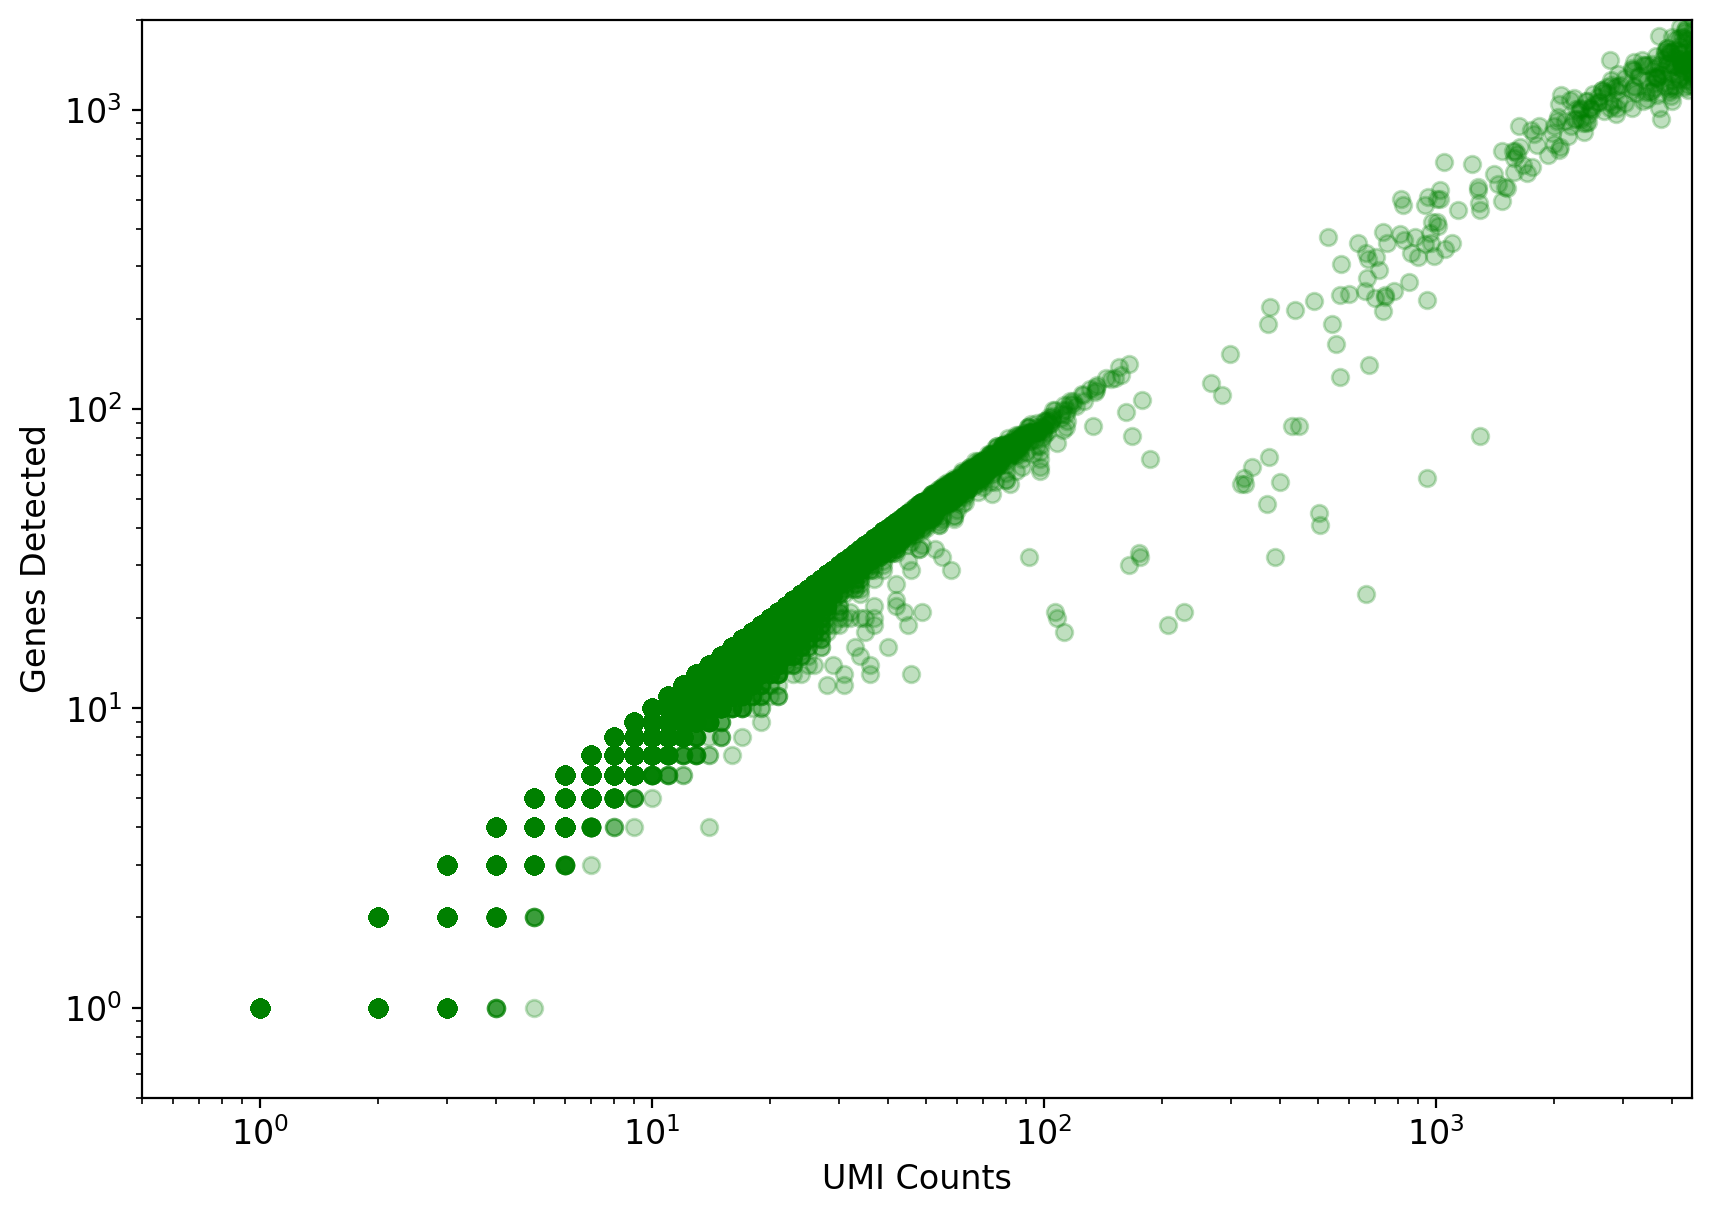

In [ ]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

The data looks good! The number of genes does not increase appreciably relative to the number of UMI counts as demonstrated by the linear relationship between genes to UMI counts in the above log-log plot.

### Examine the Knee Plot

In **microfluidics-based scRNA-seq assays**, such as the 10x Genomics Chromium platform, cells are encapsulated into droplets at low concentrations to minimize the formation of **multiplets** (droplets containing more than one cell). However, this approach also results in many droplets that contain no cells at all.

During cell dissociation and droplet generation, some mRNA molecules are released into the surrounding solution — known as **ambient RNA**. When this ambient RNA is captured and sequenced, **empty droplets** may falsely appear to contain a cell.

The **knee plot** helps distinguish real cells from empty droplets based on total UMI counts per droplet. It was first introduced in the [Drop-seq paper by Macosko et al., 2015](https://www.cell.com/fulltext/S0092-8674(15)00549-8).

In this plot, barcodes (droplets) are ranked by the number of associated UMI counts (shown on the x-axis), while the fraction of droplets with at least that many UMIs is shown on the y-axis. The “knee” of the curve represents the point where UMI counts drop sharply — separating droplets that likely contain real cells from those containing only ambient RNA.

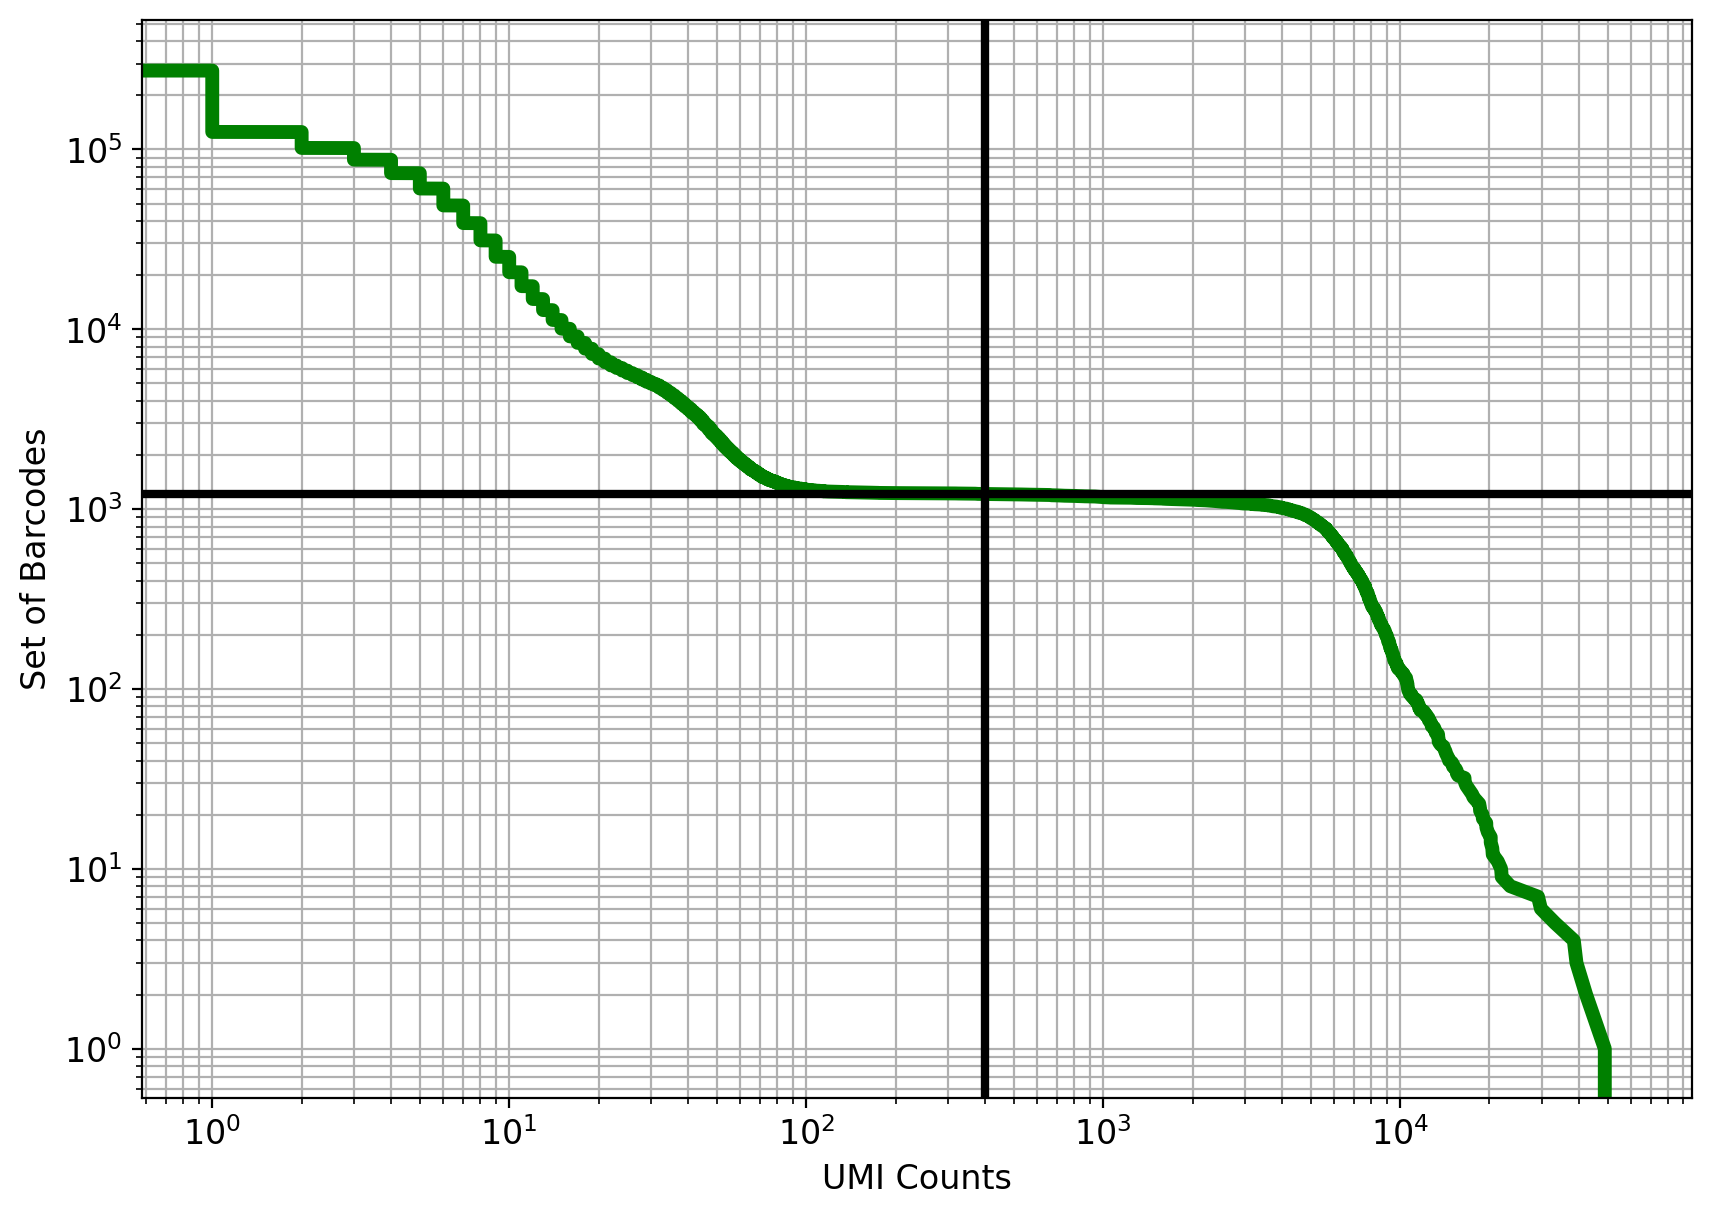

In [ ]:
#@title Threshold Cells According to Knee Plot { run: "auto", vertical-output: true }
cutoff = 400  #@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [ ]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

1,212 cells passed the 400 UMI threshold


The knee plot can be used to threshold cells based on the number of UMI counts they contain. In this example we use the number 3979 based on the publication describing the data.

## Step 3: Doublet and Multiplet Removal

### Filter empty droplets (According to the Knee Plot)

Ideally, your data will contain no empty droplets that can be mistaken for real cells. We use our results from the knee plot here to filter them out.

In [ ]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[num_cells])

:::{.callout-note}
The knee plot is a very simple method for getting rid of empty droplets. More sophisticated methods also exist. For instance, the methods **EmptyDrops**, [**CellBender**](https://github.com/broadinstitute/CellBender), and [**DecontX**](https://bioconductor.org/packages/release/bioc/html/decontX.html) use a statistical model to distinguish counts from ambient vs. cellular mRNA. This allows for both the identification and removal of empty droplets and the removal of technical noise from your count data.
:::

### Filter Multiplets with Scrublet

[**Scrublet**](https://github.com/swolock/scrublet) is an package designed to identify and remove multiplets (droplets containing more than one cell) from scRNA-seq data. It works by simulating artificial doublets through random pairwise combinations of real cells’ expression profiles. Scrublet then embeds both the simulated and observed cells in a low-dimensional space and flags real cells that lie close to simulated doublets as potential multiplets.

Scrublet operates on a raw count matrix, but requires that empty droplets be removed beforehand. If empty droplets remain in the dataset, they can distort the simulated doublet distribution and lead to inaccurate classifications. In addition, the Scrublet package should be applied to each sample/batch individually to avoid batch effects distorting the simulated doublet distribution.

Removing multiplets is an important quality-control step, as doublets can appear as hybrid cell types and obscure true biological variation during clustering and downstream analyses.

:::{.callout-note}
The Scrublet package is convenient because it is built-in to ScanPy, but it is not the only nor the most accurate doublet removal method. For a review of doublet detection methods, refer to the paper [Benchmarking computational doublet-detection methods for single-cell RNA sequencing data](https://pmc.ncbi.nlm.nih.gov/articles/PMC7897250/) by Nan Miles Chi and Jingyi Jessica Li.
:::


In [ ]:
sc.pp.scrublet(adata, expected_doublet_rate=0.008)

/usr/local/lib/python3.12/dist-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


The expected doublet rate depends upon your assay and the number of cells targeted. Refer to the documentation for you specific technology to get this number. We got the expected double rate 0.008 for 1,000 cells for 10x Chromium NextGem v3.1 [here](https://kb.10xgenomics.com/s/article/360054599512-What-is-the-cell-multiplet-rate-when-using-the-3-CellPlex-Kit-for-Cell-Multiplexing).

In [ ]:
adata = adata[adata.obs['predicted_doublet'] == False]

### Filtering Cells by Mitochondrial Content

A healthy, intact cell should have no miRNA in the cytoplasm. As such, a high percentage of miRNA in the cytosol indicates cellular damage. We will identify the number of miRNA in each cell and remove cells with a certain percentage of miRNA.

In [ ]:
mito_ensembl_ids = sc.queries.mitochondrial_genes("hsapiens", attrname="ensembl_gene_id")
mito_genes = set(mito_ensembl_ids["ensembl_gene_id"].values)

adata_base_var_names = adata.var_names.str.split('.').str[0]  # Removes minor version from var names
mito_genes_base = {gene.split('.')[0] for gene in mito_genes}  # Removes minor version from mito_genes

# Identify mitochondrial genes in adata.var using the stripped version of gene IDs
adata.var['is_mito'] = adata_base_var_names.isin(mito_genes_base)

mito_counts = adata[:, adata.var['is_mito']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = adata.X.sum(axis=1)

# Calculate percent mitochondrial gene expression per cell
adata.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/tmp/ipython-input-2771333037.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['is_mito'] = adata_base_var_names.isin(mito_genes_base)


/usr/local/lib/python3.12/dist-packages/scanpy/plotting/_anndata.py:397: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if key in adata.obs_keys():


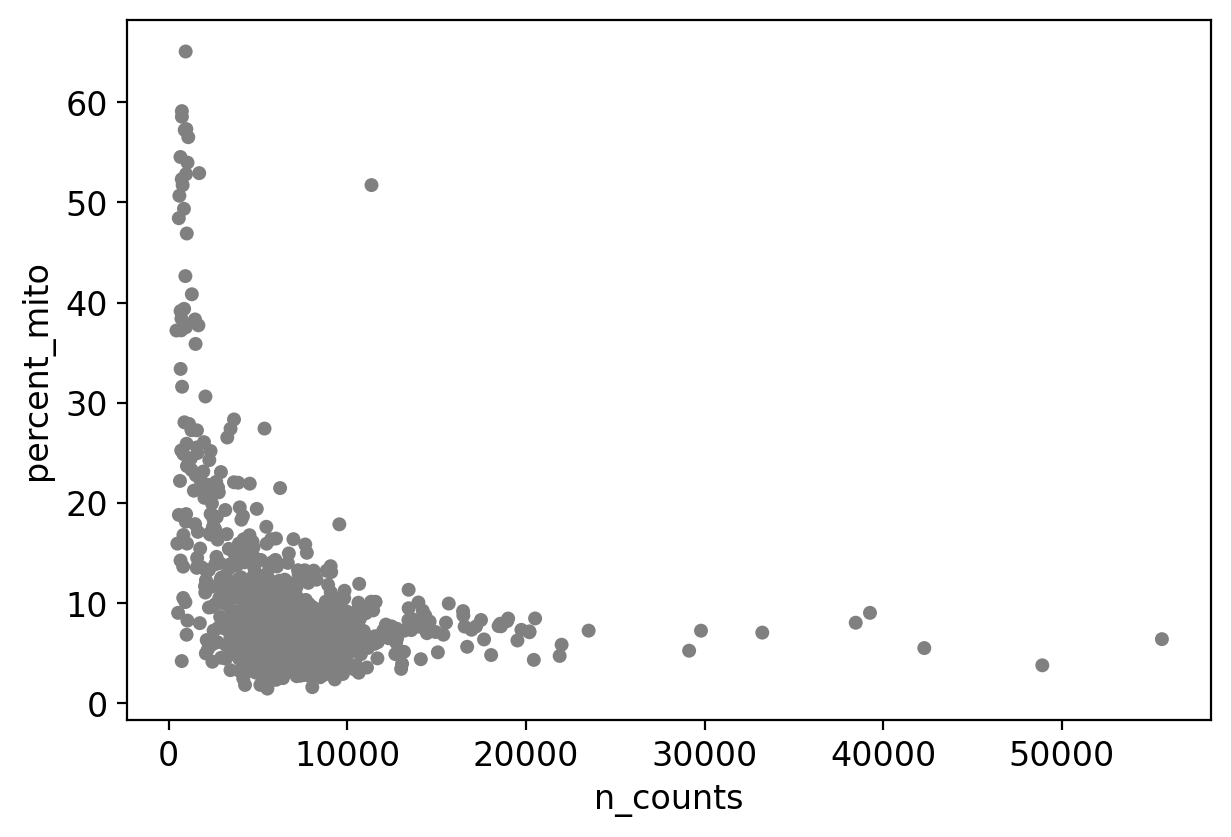

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

We see above that the highest density of cells appear to have less than 30% miRNA content, so we will set our threshold to 30%

In [ ]:
adata = adata[adata.obs.percent_mito < 30]

### Filter out genes that are not present in any cells

In general, we also want to get rid of genes with a low cell count to simplify our data.

In [ ]:
sc.pp.filter_genes(adata, min_cells=3)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


### Visualizing count distributions

Examination of the gene count and UMI count distributions is useful QC to evaluate the quality of the library and how deeply it was sequenced.

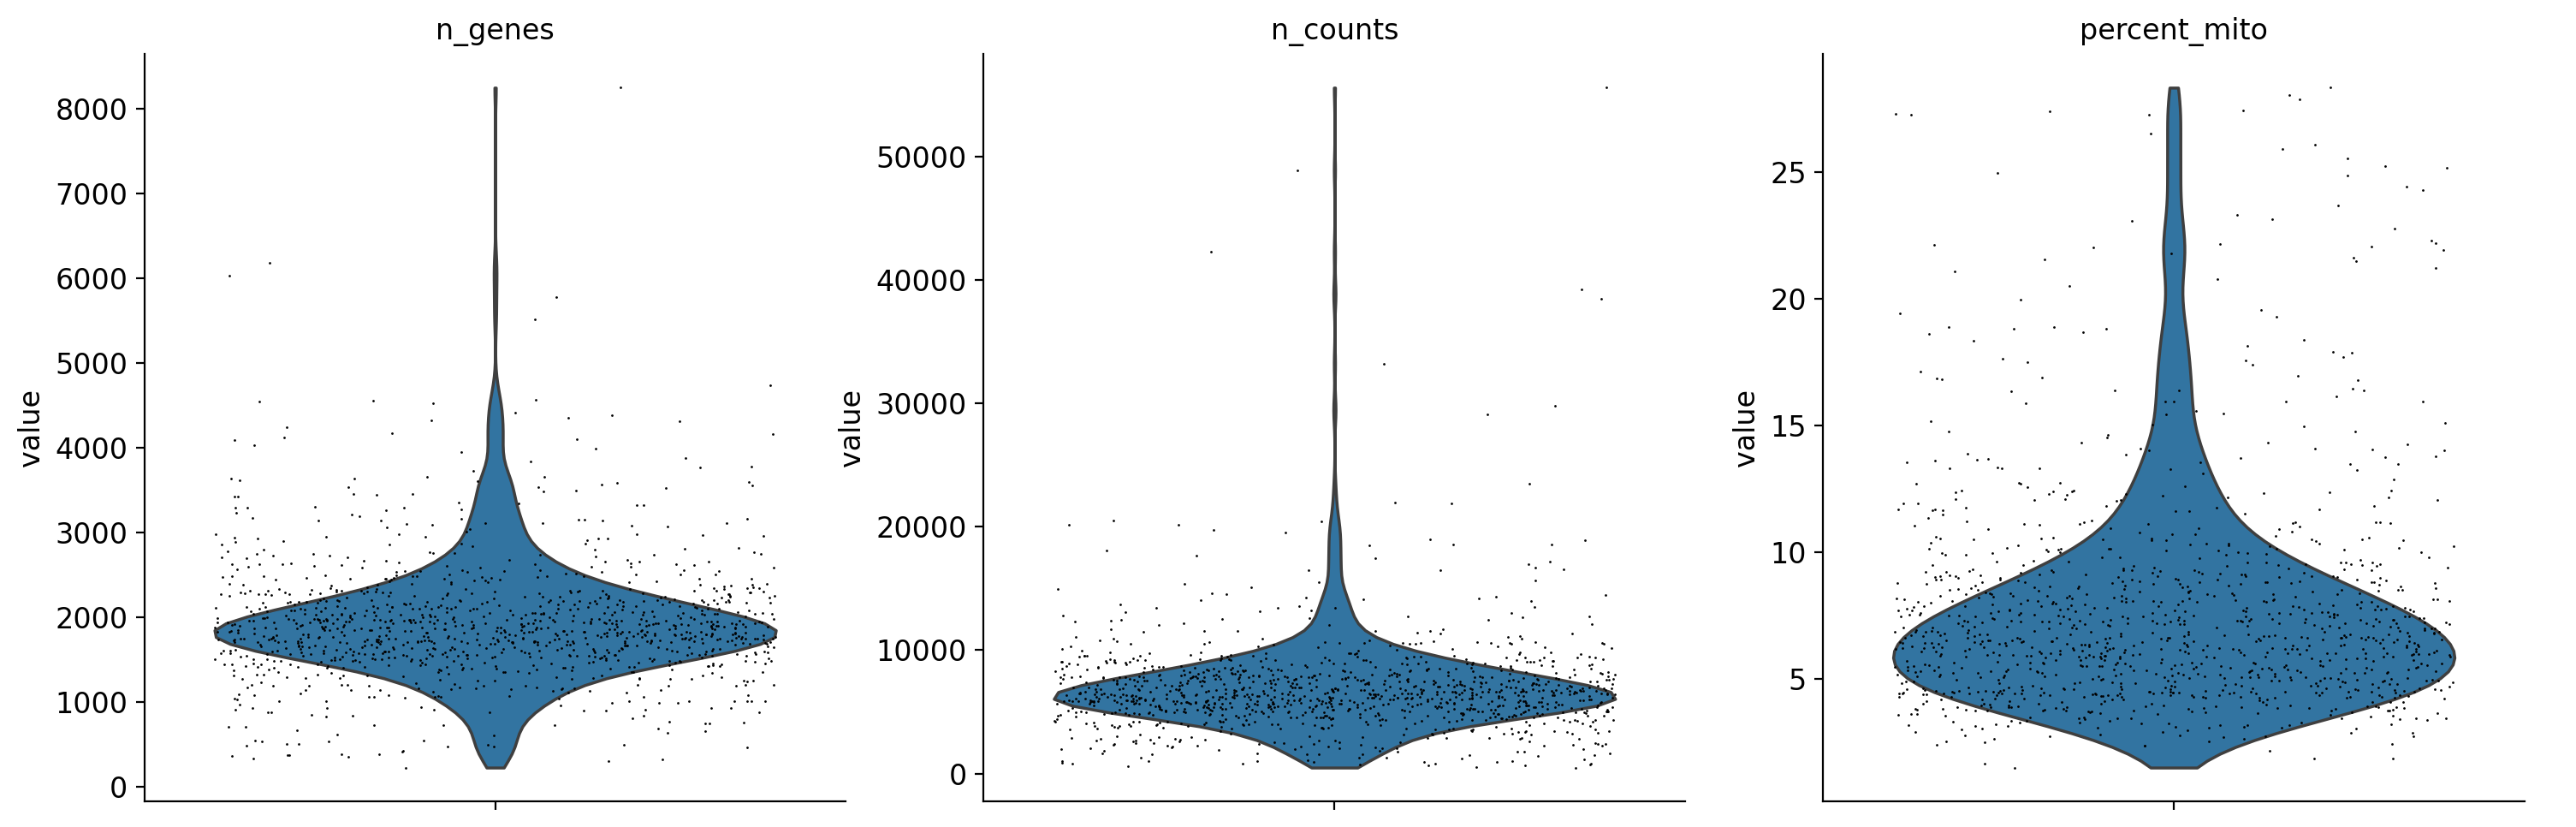

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

## Step 4: Normalization and Variance Stabilization

In an scRNA-seq experiment, UMI counts provide a relative estimate of transcript abundance within each cell. During library preparation and sequencing, mRNA molecules from different cells are reverse transcribed and sequenced to varying degrees. As a result, UMI counts cannot be interpreted as absolute measurements of RNA abundance.

To make counts comparable across cells, we normalize the data so that each cell has a total of 1×10⁶ counts. This scaling preserves integer values while allowing gene expression levels to be expressed as relative abundances within each cell.

Downstream analyses such as PCA and differential expression typically assume that gene expression values are approximately continuous and have roughly constant variance across their range. However, raw scRNA-seq counts are **overdispersed** — they follow a negative binomial–like distribution, where the variance increases with the mean. To stabilize the variance and make the data more compatible with these methods, we apply a **log transformation** to the normalized counts.

:::{.callout-note}
This is a simplified approach for addressing overdispersion. Although log normalization is widely used, it does entirely produce constant-variance data. More sophisticated methods (e.g., variance-stabilizing transformations or model-based approaches) can better correct for overdispersion, but no perfect method currently exists — and those techniques are beyond the scope of this tutorial.
:::

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e6)

In [ ]:
sc.pp.log1p(adata)

### Identify Highly Variable Genes

To simplify our data and reduce its dimensionality for downstream analyses, we limit our dataset to highly variable genes. Genes with low expression variance — such as housekeeping genes — contribute little to distinguishing between cell types or states, and can be excluded without loss of biological signal.

Here, we retain only genes with a mean expression between 0.01 and 8 (values above 8 likely indicate technical artifacts) and a minimum normalized dispersion of 1. Cells are grouped (binned) by mean gene expression, and genes within each bin are filtered based on their normalized dispersion values.

:::{.callout-note}
The `sc.pp.highly_variable_genes` function in **ScanPy** expects input data that have already been **normalized** and **variance-stabilized**.
:::

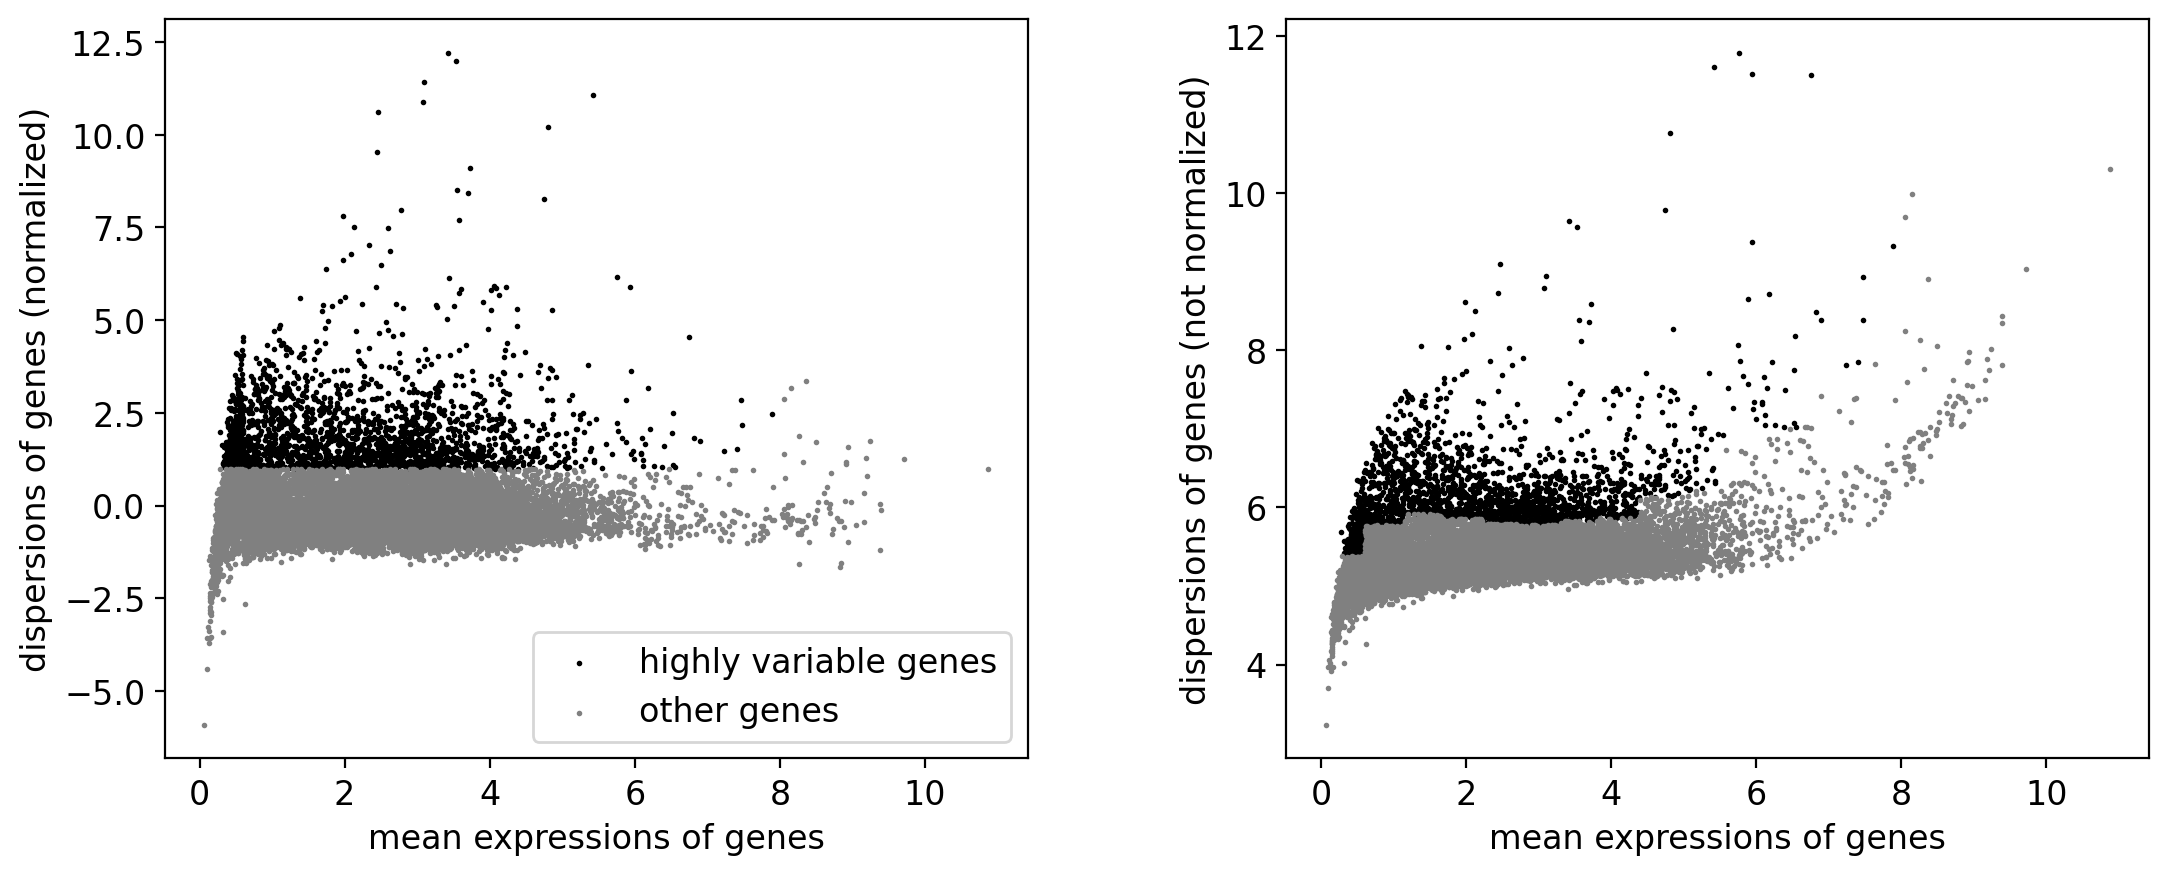

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

Finally, we scale the the data to unit variance and zero mean to standardize gene expression by preventing highly expressed genes from dominating downstream analysis and ensuring all genes are weighted equally.

In [ ]:
sc.pp.scale(adata, max_value=10)

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Step 5: Clustering and Visualization

When analyzing scRNA-seq data, **clustering** is used to identify distinct cell types and states. Subsequently, **differential expression analysis** can reveal the genes that define these cellular states.

There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks (see e.g., [Duo et al. 2018](https://f1000research.com/articles/7-1141/v2)), there is no univerally agreed upon method. Here we demonstrate clustering using **Louvain clustering**, which is a popular method for clustering single-cell RNA-seq data.

:::{.callout-note}
Louvain clustering is a non-deterministic algorithm, meaning it can produce slightly different results across runs. The number and size of clusters depend on a resolution parameter, which controls the granularity of the clustering. There is no universally optimal way to choose this parameter — it typically depends on how specific or fine-grained you want your cell populations to be.
:::

In [ ]:
sc.pp.pca(adata, mask_var="highly_variable")

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


In [ ]:
# Cluster the cells using Louvain clustering
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10, knn=True)
sc.tl.louvain(adata, resolution = 1.0)

/usr/local/lib/python3.12/dist-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


It is useful to revisit the PCA projection with points colored by cluster. Previously we computed the PCA projection directly; here we use a function in ScanPy which does the same.

### Visualization with PCA

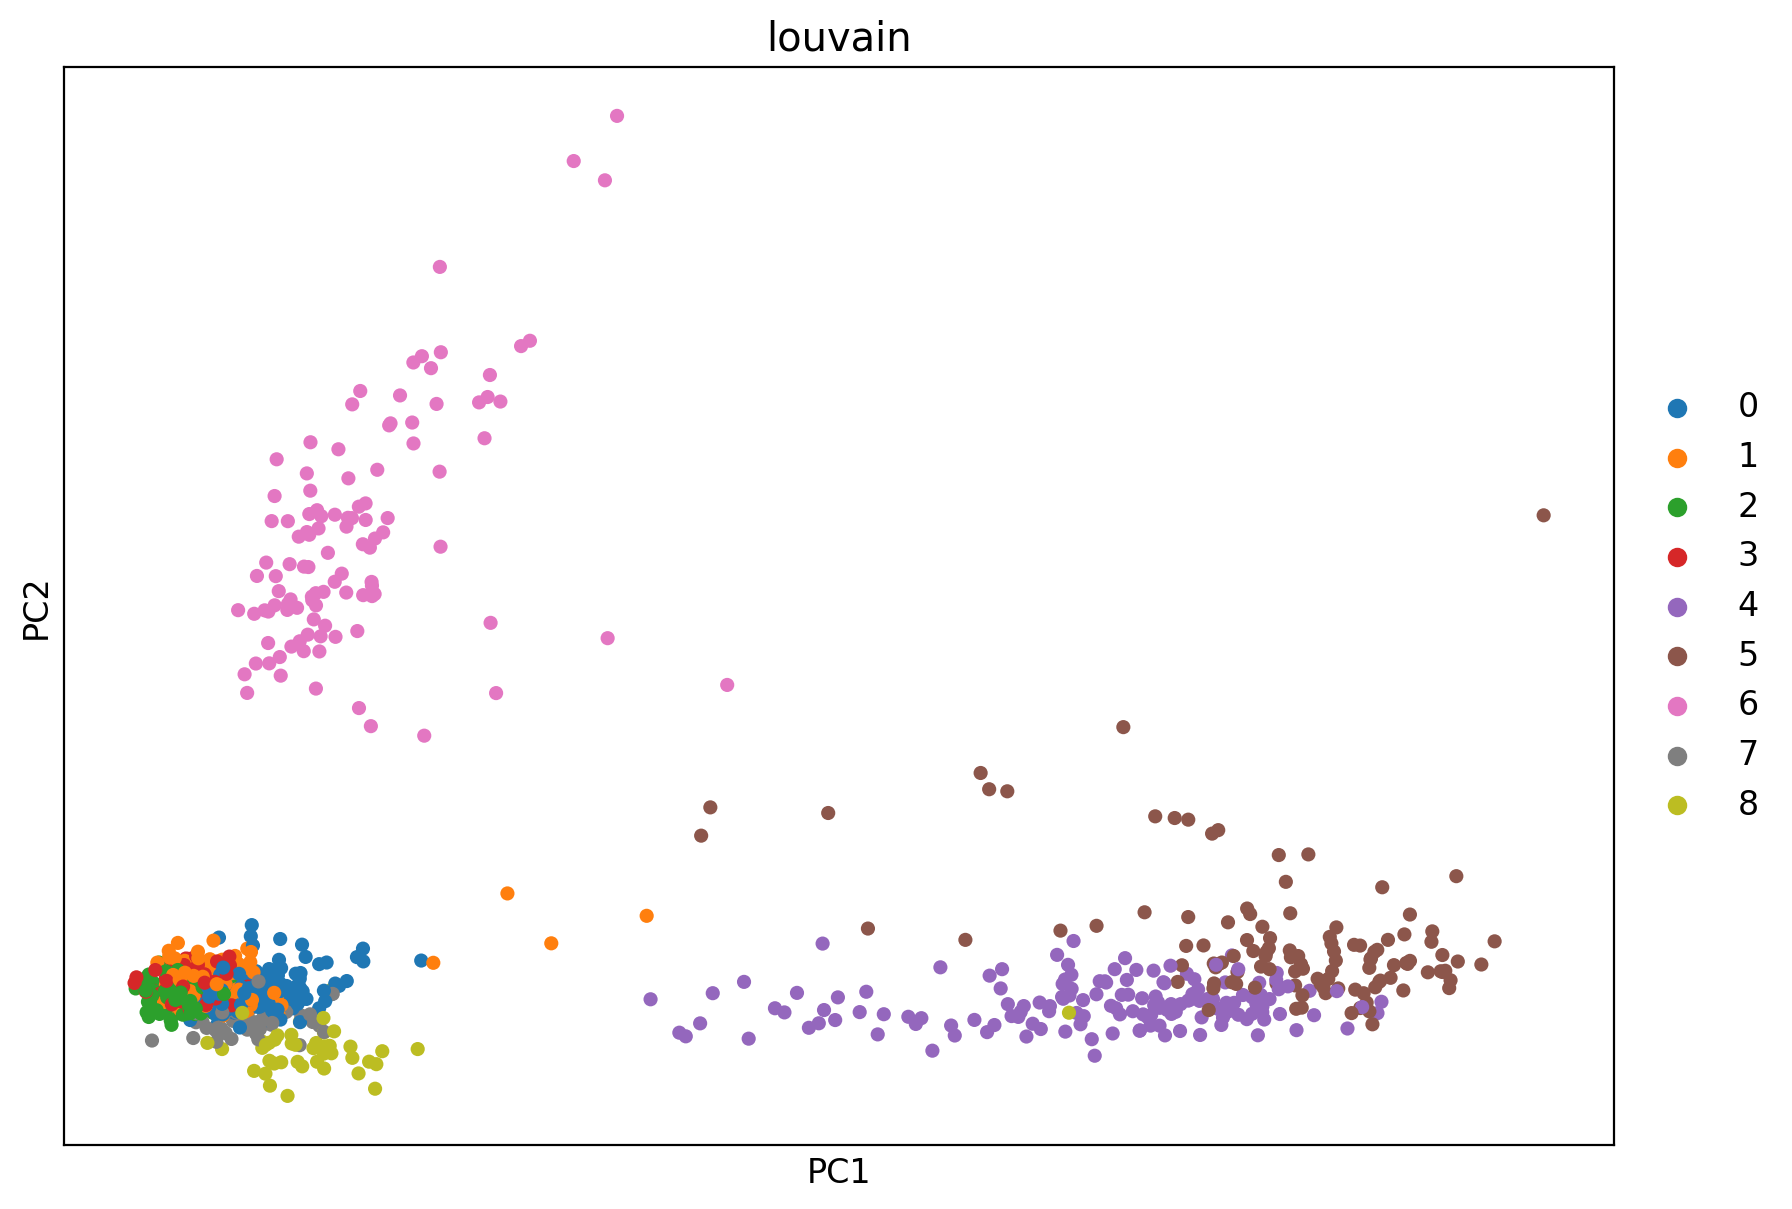

In [ ]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

### Nonlinear Visualization

The PCA representation results from a linear projection of the data from its original high-dimensional space to a lower-dimensional one (in this case, 2D). Such projections are valuable because they preserve global structure and are mathematically well-defined and reproducible.

In contrast, non-linear dimensionality reduction methods---the most popular being **t-SNE** and **UMAP**---can reveal complex, curved relationships in the data that linear methods cannot capture. However, they distort global distances and relationships, depend heavily on algorithmic parameters and random initialization, and may produce different results across runs. As a result, they are excellent for visualization but should be interpreted cautiously and not used for quantitative downstream analysis.

To read more, please see the [Pachter Lab's paper](http://biorxiv.org/lookup/doi/10.1101/2021.08.25.457696) on the drawbacks of non-linear dimensionality reduction methods.

#### t-SNE

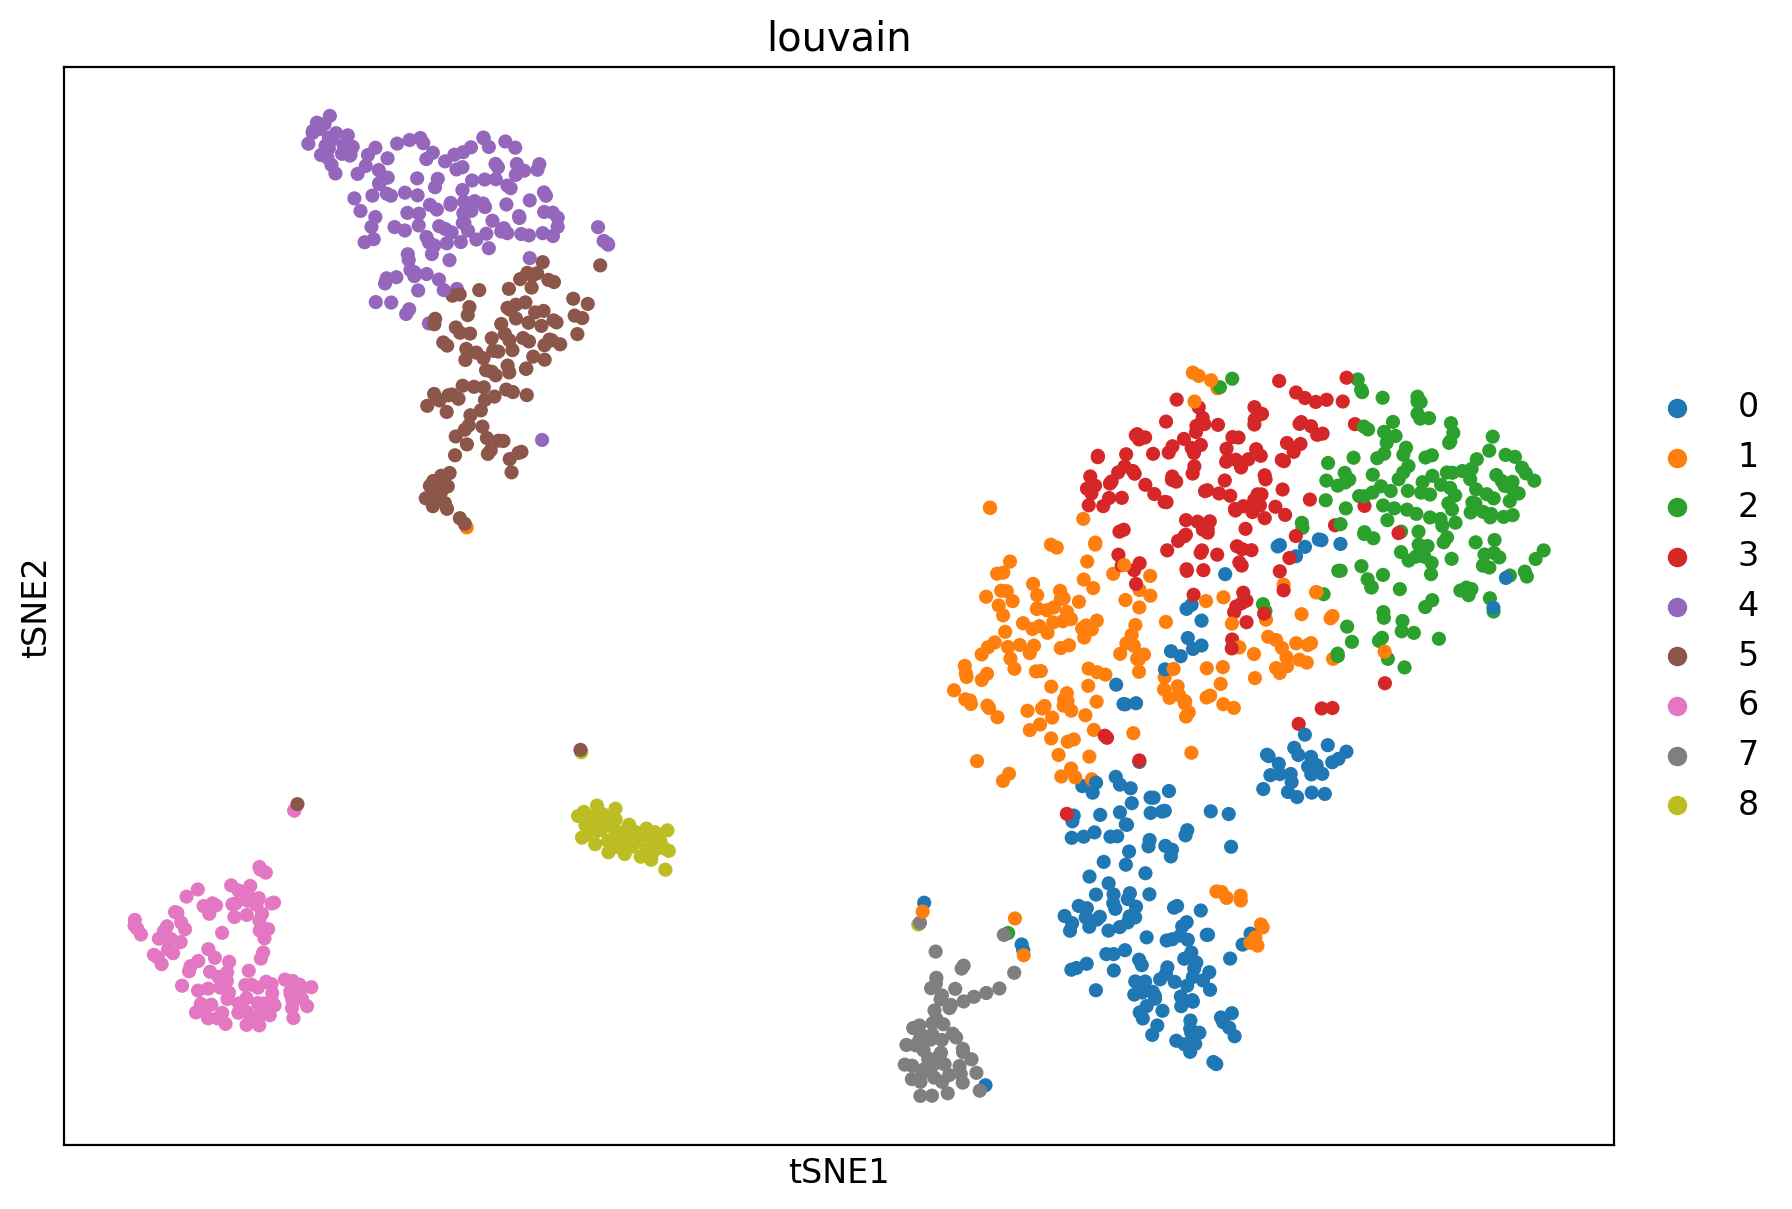

In [ ]:
# Visualize cells with t-SNE. The n_pcs parameter sets the number of principal components to project to prior to
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax)

#### UMAP

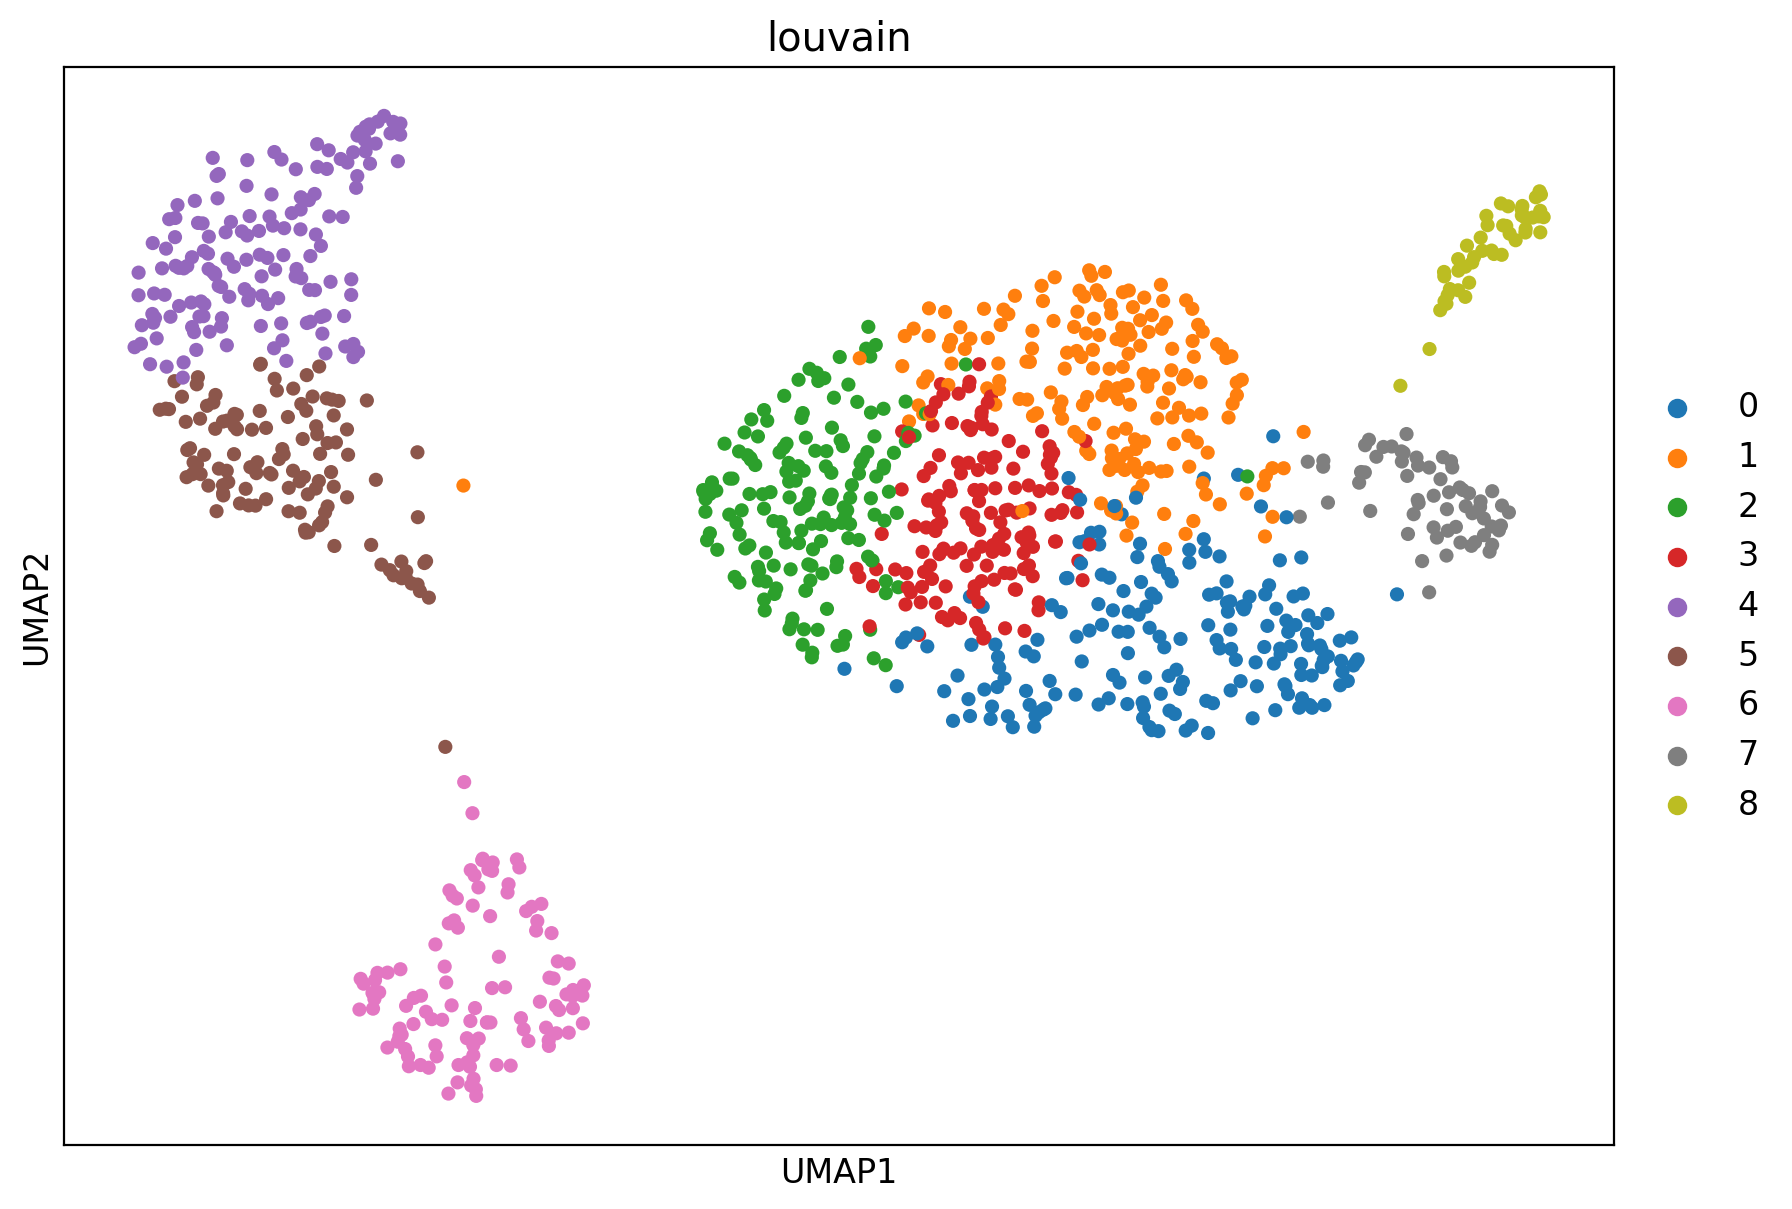

CPU times: user 3.07 s, sys: 7.18 ms, total: 3.08 s
Wall time: 2.97 s


In [ ]:
%%time
sc.tl.umap(adata)
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.umap(adata, color='louvain', ax=ax)

## Step 6: Differential Analysis

From our clustering of cell states, we can perform **differential expression analysis** to identify **marker genes** that distinguish one cell state or cluster from another. This is typically done using simple statistical tests — such as the **Wilcoxon rank-sum test** or the **t-test** — which compare gene expression levels between clusters, or alternatively by fitting a more complex statistical model that accounts for variability across cells. By examining which genes are upregulated in each cluster, we can annotate clusters with known cell identities or infer novel cellular subpopulations.

Below, we use the **Wilcoxon rank-sum test** to identify marker genes. Because we are performing multiple hypothesis tests on the same dataset, we must adjust our p-values to control the false discovery rate. Several correction methods exist, but here we apply the **Benjamini–Hochberg procedure**, a widely used approach for multiple testing correction.

:::{.callout-note}
Statistical tests such as the **Wilcoxon rank-sum test** and the **t-test** assume that the groups being compared were defined independently of the data. However, in single-cell analysis, clustering algorithms like Louvain define groups based on the data itself — by minimizing within-cluster variation and maximizing between-cluster separation. This violates the independence assumption, meaning these tests are not strictly valid. Despite this, they remain common in practice and can still provide useful exploratory insights when interpreted cautiously.
:::

In [ ]:
sc.tl.rank_genes_groups(adata, gene_symbols='gene_names', groupby='louvain', method='wilcoxon')

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

The below plot shows the 10 most highly expressed genes in each cluster (compared to the other clusters) according to the Wilcoxon z-score.

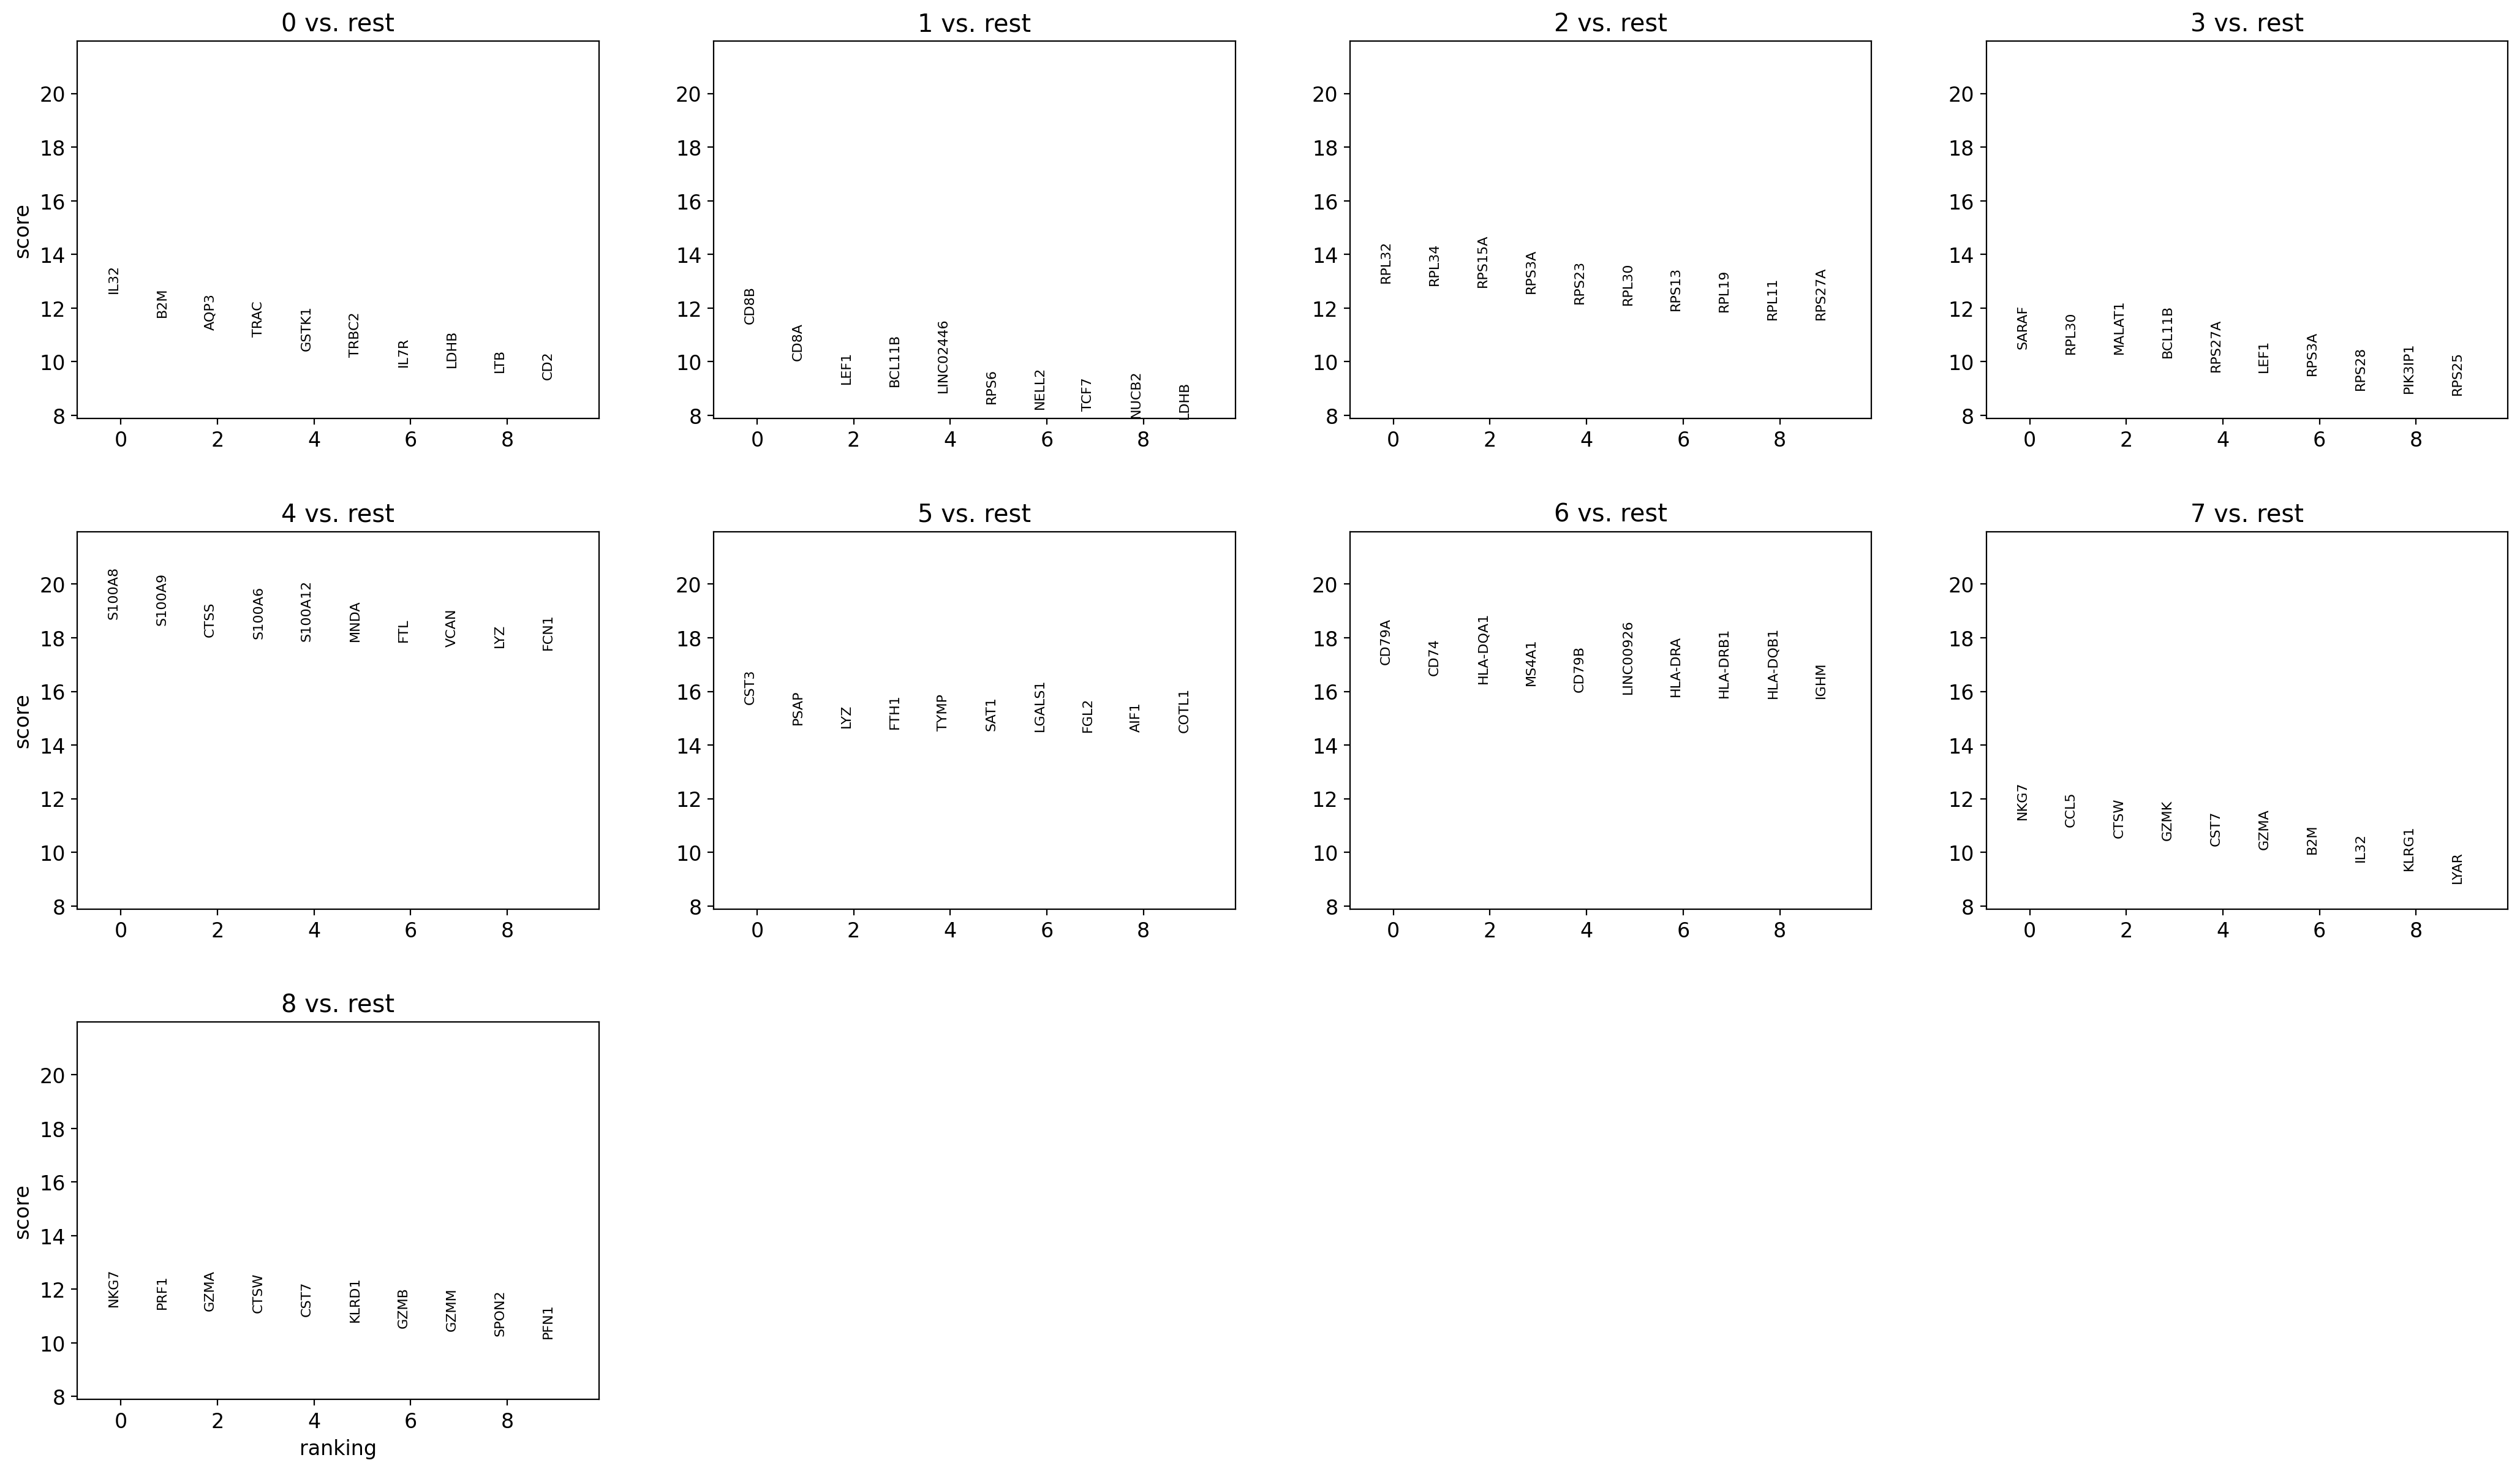

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=10, gene_symbols='gene_names', groupby='louvain', method='wilcoxon')